# Clasificación con XGBoost

| Nº | Columna                    | Tipo               | Descripción                                                                     |
| -- | -------------------------- | ------------------ | ------------------------------------------------------------------------------- |
| 1  | `Pregnancies`              | Numérico           | Número de embarazos que ha tenido la paciente.                                  |
| 2  | `Glucose`                  | Numérico           | Nivel de glucosa en sangre en una prueba de tolerancia a la glucosa.            |
| 3  | `BloodPressure`            | Numérico           | Presión arterial diastólica (mm Hg).                                            |
| 4  | `SkinThickness`            | Numérico           | Grosor del pliegue cutáneo del tríceps (mm), usado para estimar grasa corporal. |
| 5  | `Insulin`                  | Numérico           | Nivel de insulina sérica (mu U/ml).                                             |
| 6  | `BMI`                      | Numérico           | Índice de masa corporal: peso en kg / (altura en m)^2.                          |
| 7  | `DiabetesPedigreeFunction` | Numérico           | Función de antecedentes genéticos de diabetes (influencia hereditaria).         |
| 8  | `Age`                      | Numérico           | Edad del paciente (en años).                                                    |
| 9  | `Outcome`                  | Categórica (0 o 1) | Variable objetivo: 1 si la persona tiene diabetes, 0 si no.                     |


Dependencias

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

1. Cargar datos

In [ ]:
df = pd.read_csv("../../datasets/diabetes/pima-indians-diabetes.csv", header=0)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


 3. Análisis Exploratorio (EDA)

In [3]:
print("Primeras filas:")
print(df.head())

Primeras filas:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
print("\nInformación general:")
print(df.info())


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [5]:
print("\nEstadísticas:")
print(df.describe())


Estadísticas:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000   

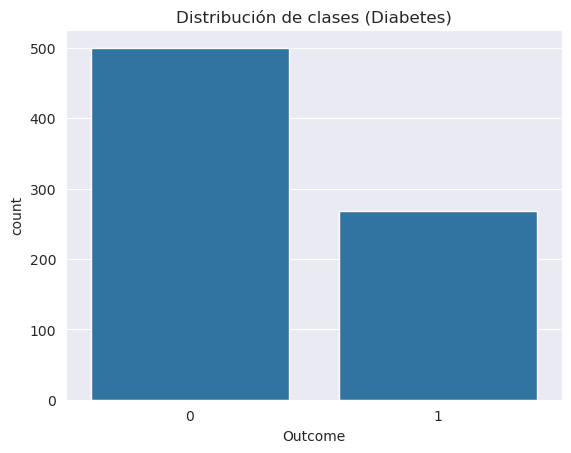

In [6]:
# Distribución del objetivo
sns.countplot(x='Outcome', data=df)
plt.title("Distribución de clases (Diabetes)")
plt.show()

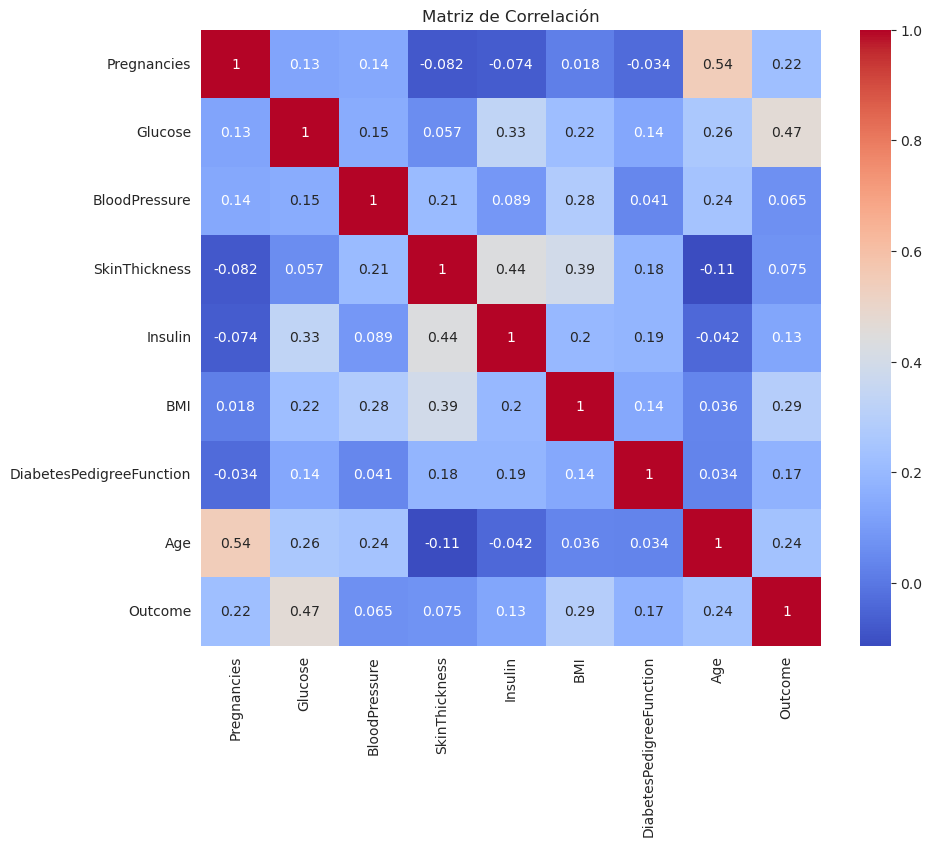

In [7]:
# Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

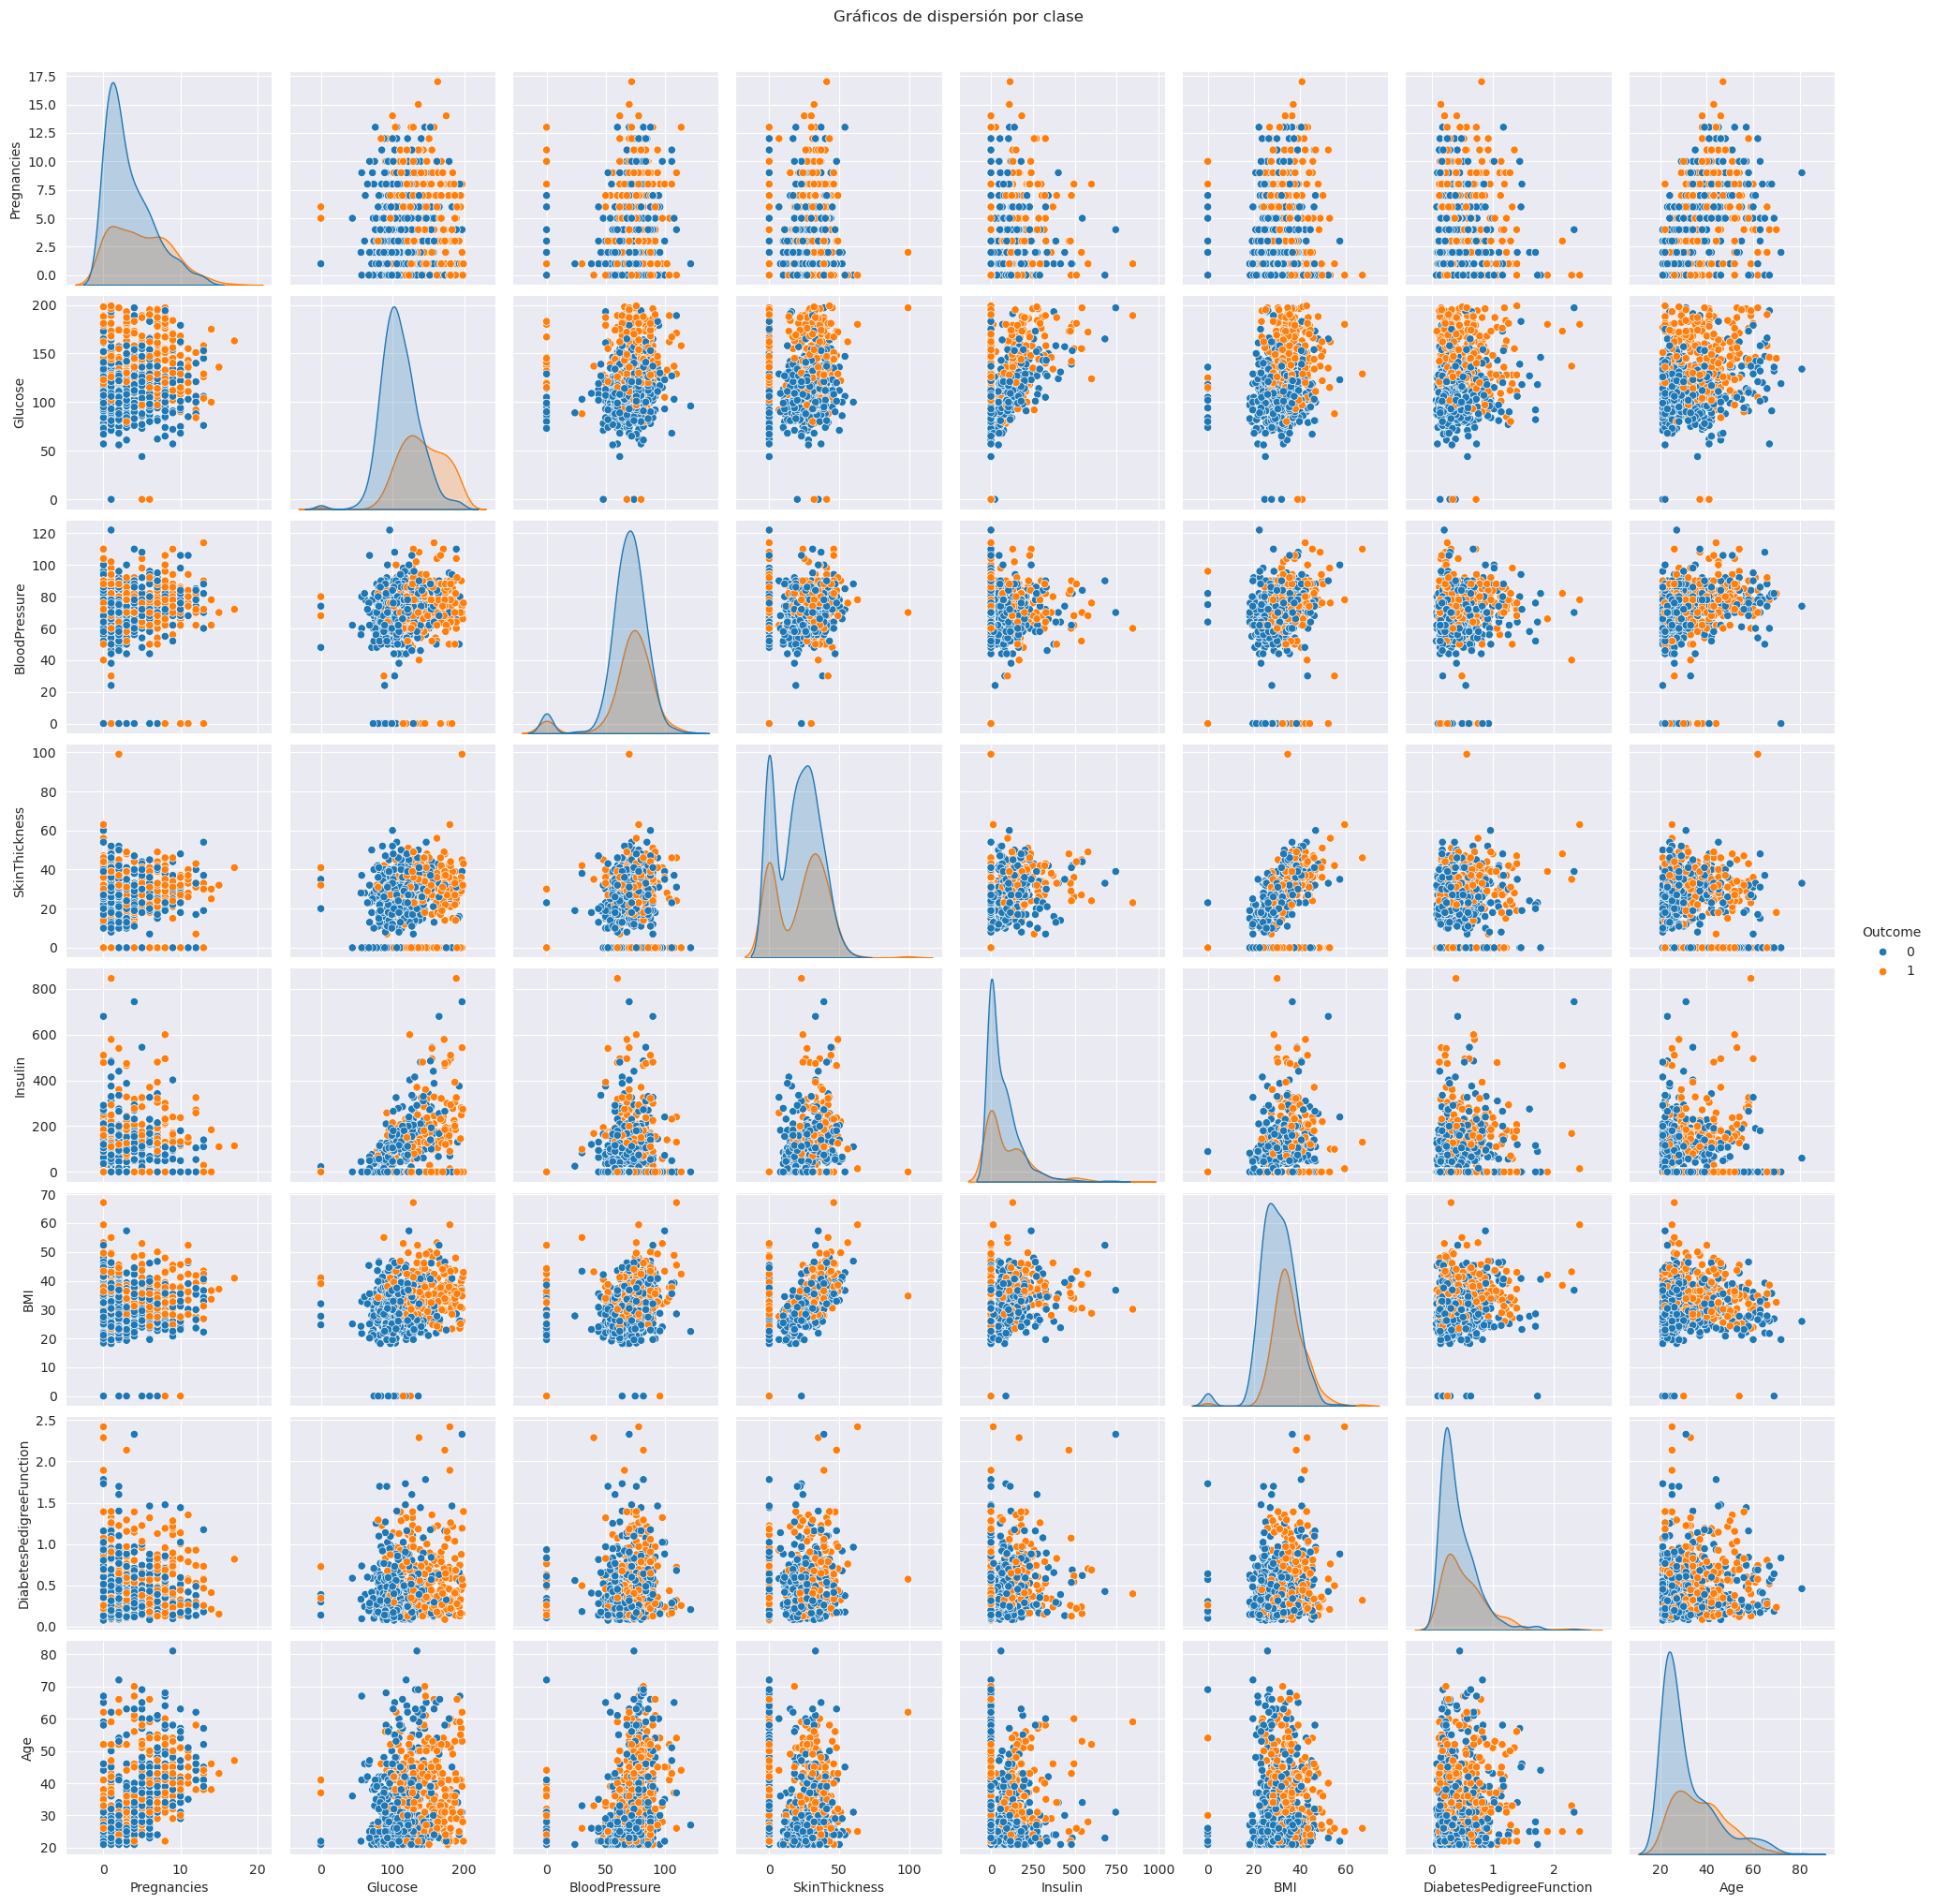

In [8]:
sns.pairplot(df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']], hue='Outcome')
plt.suptitle("Gráficos de dispersión por clase", y=1.02)
plt.show()

3. Limpieza y tratamiento de nulos

In [9]:
# Reemplazar ceros por NaN en columnas que no deberían tener cero
cols_with_zero_as_nan = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero_as_nan] = df[cols_with_zero_as_nan].replace(0, np.nan)

In [10]:
# Imputación con la mediana
imputer = SimpleImputer(strategy='median')
df[cols_with_zero_as_nan] = imputer.fit_transform(df[cols_with_zero_as_nan])

In [11]:
print("\nValores nulos después de imputación:")
print(df.isnull().sum())


Valores nulos después de imputación:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


4. Transformación de variables

Separación de variables

In [12]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

Escalado

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Separación del conjunto de datos

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

5. Entrenamiento y validación del modelo

Modelo

In [15]:
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [16]:
clf.fit(X_train, y_train)

/home/tuteggito/miniconda3/envs/machine-learning-examples/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:59:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

Evaluación del modelo

In [17]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

In [18]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       150
           1       0.67      0.60      0.64        81

    accuracy                           0.76       231
   macro avg       0.73      0.72      0.73       231
weighted avg       0.75      0.76      0.75       231



In [19]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[126  24]
 [ 32  49]]


In [20]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.7575757575757576
ROC AUC: 0.8028806584362139


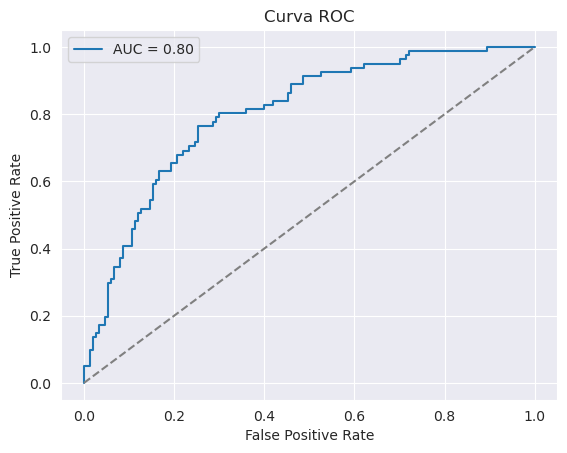

In [21]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()

Importancia de las variables

<Figure size 1000x600 with 0 Axes>

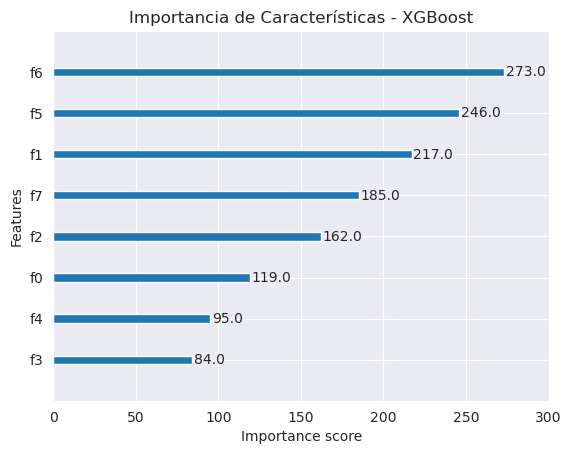

In [22]:
plt.figure(figsize=(10, 6))
plot_importance(clf)
plt.title("Importancia de Características - XGBoost")
plt.show()

Buscar mejores parámetros

In [24]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

In [25]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [26]:
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

In [27]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/home/tuteggito/miniconda3/envs/machine-learning-examples/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:02:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tuteggito/miniconda3/envs/machine-learning-examples/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:02:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tuteggito/miniconda3/envs/machine-learning-examples/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:02:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tuteggito/miniconda3/envs/machine-learning-examples/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:02:40] WARNING: /workspace/src/learner.cc:738: 
Paramet

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [2, 3, 4], 'n_estimators': [50, 100, 150],
                         'subsample': [0.8, 1]},
             scoring='roc_auc', verbose=1)

In [28]:
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

Mejores parámetros encontrados:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.8}


In [29]:
print("\nMejor puntuación AUC en validación cruzada:")
print(grid_search.best_score_)


Mejor puntuación AUC en validación cruzada:
0.8126257728593657


In [30]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [31]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       150
           1       0.66      0.54      0.59        81

    accuracy                           0.74       231
   macro avg       0.72      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231



In [32]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[127  23]
 [ 37  44]]


In [33]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.7402597402597403
ROC AUC: 0.836954732510288
